In [2]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import datetime as dt
from difflib import get_close_matches
import matplotlib.pyplot as plt
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

/home/robmulla/miniconda3/envs/w266/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
good_data_games = pd.read_csv('../../data/Good_Games_with_DateGameNames.csv')
winpct = pd.read_csv('../../data/All_plays_Feb17.csv')
playbyplay = pd.read_csv('../../data/All_tweets_Feb17.csv')

In [4]:
# List of all the games we have win percentages and timestamps for
good_data_games['matched_game_date']

0          Broncos vs. Chiefs  2017-10-30
1        Packers vs. Panthers  2017-12-17
2        Vikings vs. Panthers  2017-12-10
3          Steelers vs. Lions  2017-10-29
4        Raiders vs. Redskins  2017-09-24
5         Vikings vs. Packers  2017-12-23
6         Packers vs. Vikings  2017-10-15
7        Redskins vs. Cowboys  2017-11-30
8          Raiders vs. Eagles  2017-12-25
9           Lions vs. Packers  2017-11-06
10       Chargers vs. Cowboys  2017-11-23
11     Falcons vs. Buccaneers  2017-12-18
12        Cowboys vs. Raiders  2017-12-17
13         Giants vs. Cowboys  2017-09-10
14         Saints vs. Vikings  2017-09-11
15       Patriots vs. Broncos  2017-11-12
16     Seahawks vs. Cardinals  2017-11-09
17             Rams vs. 49ers  2017-09-21
18       Falcons vs. Seahawks  2017-11-20
19        Redskins vs. Chiefs  2017-10-02
20      Cowboys vs. Cardinals  2017-09-25
21         Texans vs. Bengals  2017-09-14
22         Saints vs. Falcons  2017-12-07
23        Redskins vs. Eagles  201

(1:47) D.Lewis left tackle to NE 40 for -3 yards (M.Jackson).
172    (2:00) (Shotgun) B.Bortles pass short right to...
173    (1:53) (Shotgun) B.Bortles pass incomplete dee...
174    (1:47) D.Lewis left tackle to NE 40 for -3 yar...
175                 Timeout #1 by JAX at 01:42. #NEvsJAX
176    (1:42) D.Lewis right guard to NE 44 for 4 yard...
177                 Timeout #2 by JAX at 01:38. #NEvsJAX
Name: text_cleaned, dtype: object
('(1:47) D.Lewis left tackle to NE 40 for -3 yards (M.Jackson). #NEvsJAX', 93, 174)


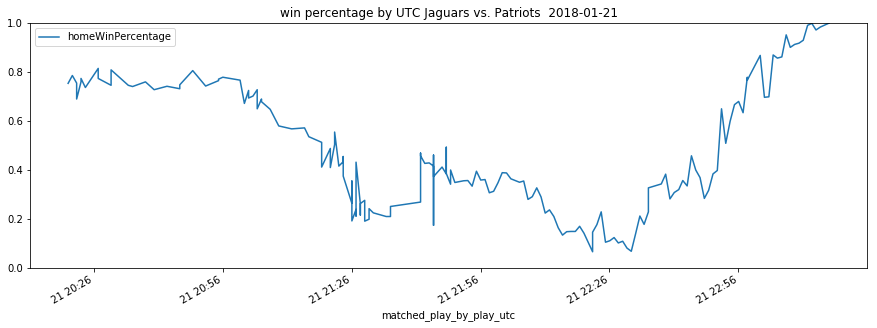

In [122]:
game = good_data_games.loc[35]['matched_game_date']
thread = good_data_games.loc[35]['Thread ID']
try:
    # filter win percentage 
    game_winpct = winpct.loc[winpct['Game Title Date'] == game].copy().reset_index()
    game_playbyplay = playbyplay.loc[playbyplay['Game Title Date'] == game].copy().reset_index()

    # Plot play by play to make sure it looks reasonible
    #game_playbyplay.plot('UTC_Datetime', y='tweet_id', figsize=(15,5), title='Tweets timeline : {}'.format(game))

    # Loop through win percent and match with play by play get UTC
    first_index = 0
    for i in game_winpct.iterrows():
        pbp_text = i[1]['text']
        # print(pbp_text)
        next_10_playbyplay = game_playbyplay['text_cleaned'][max(0,first_index-1):first_index+5]
        match = process.extractOne(pbp_text, next_10_playbyplay, scorer=fuzz.token_sort_ratio)
        if i[0] == 165:
            print(pbp_text)
            print(next_10_playbyplay)
            print(match)
        # print(match)
        match_text, match_percent, match_index = match
        game_winpct.loc[i[0], 'matched_play_by_play_text'] = match_text
        game_winpct.loc[i[0], 'matched_play_by_play_index'] = match_index
        game_winpct.loc[i[0], 'matched_play_by_play_utc'] = game_playbyplay.loc[match_index]['UTC_Datetime']
        game_winpct.loc[i[0], 'matched_play_by_play_tweetid'] = game_playbyplay.loc[match_index]['tweet_id']
        first_index = match_index

    game_winpct['matched_play_by_play_utc'] = pd.to_datetime(game_winpct['matched_play_by_play_utc'])
    game_winpct.plot(x='matched_play_by_play_utc', y='homeWinPercentage', ylim=(0,1), figsize=(15,5), title='win percentage by UTC {}'.format(game))

    game_winpct['home_team'] = game_winpct.loc[0, 'Game Title Date'].split()[2]
    game_winpct['away_team'] = game_winpct.loc[0, 'Game Title Date'].split()[0]
    game_winpct['awayWinPercentage'] = 1 - game_winpct['homeWinPercentage']

    # Save to CSV
    filename = game.replace(' ','_').replace('.','') + '_UTCandWinPCT.csv'
    game_winpct.to_csv('../../data/Clean_Game_Data/' + filename)

    df = game_winpct.copy()
    df['UTC_Datetime'] = pd.to_datetime(df['matched_play_by_play_utc'])

    # Load Comments
    comments = pd.read_pickle('../../../data/{}_parsed_comments.pickle'.format(thread))
    comments = comments.sort_values('comment_created_utc_datetime')
    # Loop through comments

    only_greater = df.copy()

    playidlist = []

    for row in comments['comment_created_utc_datetime']:
        mytime = row + timedelta(hours=5)
        only_greater = only_greater.loc[df['UTC_Datetime'] >= mytime]
        try:
            playid_attime = only_greater.head(1)['playId'].values[0]
            playidlist.append(playid_attime)
        except:
            playidlist.append(playid_attime)

    comments['playId'] = playidlist
    merged = comments.merge(game_winpct, on='playId')

    # Calculate Sentiment
    sid = SentimentIntensityAnalyzer()

    def calculate_VADER(comment):
        comment = str(comment)
        ss = sid.polarity_scores(comment)
        neg = ss['neg']
        neu = ss['neu']
        pos = ss['pos']
        compound = ss['compound']
        return ss, neg, neu, pos, compound

    def vader_df(df, textcol = 'text'):
        df['vader_ss'], df['vader_neg'], df['vader_neu'], df['vader_pos'], df['vader_compound'] = \
        zip(*df[textcol].map(calculate_VADER))
        return df

    merged_with_sentiment = vader_df(merged, textcol='comment_body')
    merged_with_sentiment.to_pickle('../../data/Clean_Game_Data/{}'.format(game.replace(' ','_').replace('.','')+'_comment_sentiment.pickle'))
except:
    print('Broke for {}'.format(game))
    raise

In [116]:
game_playbyplay.tail(5)

,index,tweet_id,Game Title Date,text_cleaned,UTC_Datetime,playnum,playId,Game Title Date.1,text,homeWinPercentage
374,57940,9.379079e+17,Steelers vs. Bengals 2017-12-04,Timeout #3 by PIT at 00:04. #CINvsPIT,2017-12-05 04:54:05,NaN,NaN,NaN,NaN,NaN
375,57941,9.379082e+17,Steelers vs. Bengals 2017-12-04,(:04) (Field Goal formation) PENALTY on https:...,2017-12-05 04:55:06,NaN,NaN,NaN,NaN,NaN
376,57942,9.379082e+17,Steelers vs. Bengals 2017-12-04,(:04) (Field Goal formation) PENALTY on https:...,2017-12-05 04:55:06,NaN,NaN,NaN,NaN,NaN
377,57943,9.379084e+17,Steelers vs. Bengals 2017-12-04,(:04) C.Boswell 38 yard field goal is GOOD Cen...,2017-12-05 04:56:04,NaN,NaN,NaN,NaN,NaN
378,57944,9.379084e+17,Steelers vs. Bengals 2017-12-04,(:04) C.Boswell 38 yard field goal is GOOD Cen...,2017-12-05 04:56:04,NaN,NaN,NaN,NaN,NaN
